# Session 2 - Training a Network w/ Tensorflow
<p class="lead">
Assignment: Teach a Deep Neural Network to Paint
</p>

<p class="lead">
Parag K. Mital<br />
<a href="https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info">Creative Applications of Deep Learning w/ Tensorflow</a><br />
<a href="https://www.kadenze.com/partners/kadenze-academy">Kadenze Academy</a><br />
<a href="https://twitter.com/hashtag/CADL">#CADL</a>
</p>

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

# Learning Goals

* Learn how to create a Neural Network
* Learn to use a neural network to paint an image
* Apply creative thinking to the inputs, outputs, and definition of a network

# Outline

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Assignment Synopsis](#assignment-synopsis)
- [Part One - Fully Connected Network](#part-one---fully-connected-network)
    - [Instructions](#instructions)
    - [Code](#code)
    - [Variable Scopes](#variable-scopes)
- [Part Two - Image Painting Network](#part-two---image-painting-network)
    - [Instructions](#instructions-1)
    - [Preparing the Data](#preparing-the-data)
    - [Cost Function](#cost-function)
    - [Explore](#explore)
    - [A Note on Crossvalidation](#a-note-on-crossvalidation)
- [Part Three - Learning More than One Image](#part-three---learning-more-than-one-image)
    - [Instructions](#instructions-2)
    - [Code](#code-1)
- [Part Four - Open Exploration \(Extra Credit\)](#part-four---open-exploration-extra-credit)
- [Assignment Submission](#assignment-submission)

<!-- /MarkdownTOC -->

This next section will just make sure you have the right version of python and the libraries that we'll be using.  Don't change the code here but make sure you "run" it (use "shift+enter")!

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n' \
          'You should consider updating to Python 3.4.0 or ' \
          'higher as the libraries built for this course ' \
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda '
          'and then restart `jupyter notebook`:\n' \
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, gif
    import IPython.display as ipyd
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="assignment-synopsis"></a>
# Assignment Synopsis

In this assignment, we're going to create our first neural network capable of taking any two continuous values as inputs.  Those two values will go through a series of multiplications, additions, and nonlinearities, coming out of the network as 3 outputs.  Remember from the last homework, we used convolution to filter an image so that the representations in the image were accentuated.  We're not going to be using convolution w/ Neural Networks until the next session, but we're effectively doing the same thing here: using multiplications to accentuate the representations in our data, in order to minimize whatever our cost function is.  To find out what those multiplications need to be, we're going to use Gradient Descent and Backpropagation, which will take our cost, and find the appropriate updates to all the parameters in our network to best optimize the cost.  In the next session, we'll explore much bigger networks and convolution.  This "toy" network is really to help us get up and running with neural networks, and aid our exploration of the different components that make up a neural network.  You will be expected to explore manipulations of the neural networks in this notebook as much as possible to help aid your understanding of how they effect the final result.

We're going to build our first neural network to understand what color "to paint" given a location in an image, or the row, col of the image.  So in goes a row/col, and out goes a R/G/B.  In the next lesson, we'll learn what this network is really doing is performing regression.  For now, we'll focus on the creative applications of such a network to help us get a better understanding of the different components that make up the neural network.  You'll be asked to explore many of the different components of a neural network, including changing the inputs/outputs (i.e. the dataset), the number of layers, their activation functions, the cost functions, learning rate, and batch size.  You'll also explore a modification to this same network which takes a 3rd input: an index for an image.  This will let us try to learn multiple images at once, though with limited success.

We'll now dive right into creating deep neural networks, and I'm going to show you the math along the way.  Don't worry if a lot of it doesn't make sense, and it really takes a bit of practice before it starts to come together.

<a name="part-one---fully-connected-network"></a>
# Part One - Fully Connected Network

<a name="instructions"></a>
## Instructions
Create the operations necessary for connecting an input to a network, defined by a `tf.Placeholder`, to a series of fully connected, or linear, layers, using the formula:  

$$\textbf{H} = \phi(\textbf{X}\textbf{W} + \textbf{b})$$

where $\textbf{H}$ is an output layer representing the "hidden" activations of a network, $\phi$ represents some nonlinearity, $\textbf{X}$ represents an input to that layer, $\textbf{W}$ is that layer's weight matrix, and $\textbf{b}$ is that layer's bias.  

If you're thinking, what is going on?  Where did all that math come from?  Don't be afraid of it.  Once you learn how to "speak" the symbolic representation of the equation, it starts to get easier.  And once we put it into practice with some code, it should start to feel like there is some association with what is written in the equation, and what we've written in code.  Practice trying to say the equation in a meaningful way: "The output of a hidden layer is equal to some input multiplied by another matrix, adding some bias, and applying a non-linearity".  Or perhaps: "The hidden layer is equal to a nonlinearity applied to an input multiplied by a matrix and adding some bias".  Explore your own interpretations of the equation, or ways of describing it, and it starts to become much, much easier to apply the equation.

The first thing that happens in this equation is the input matrix $\textbf{X}$ is multiplied by another matrix, $\textbf{W}$.  This is the most complicated part of the equation.  It's performing matrix multiplication, as we've seen from last session, and is effectively scaling and rotating our input.  The bias $\textbf{b}$ allows for a global shift in the resulting values.  Finally, the nonlinearity of $\phi$ allows the input space to be nonlinearly warped, allowing it to express a lot more interesting distributions of data.  Have a look below at some common nonlinearities.  If you're unfamiliar with looking at graphs like this, it is common to read the horizontal axis as X, as the input, and the vertical axis as Y, as the output.

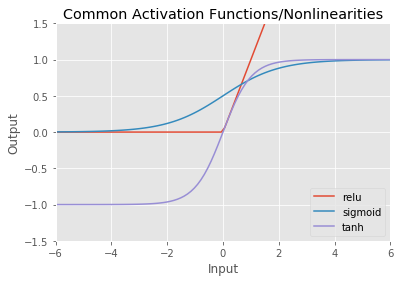

In [3]:
xs = np.linspace(-6, 6, 100)
plt.plot(xs, np.maximum(xs, 0), label='relu')
plt.plot(xs, 1 / (1 + np.exp(-xs)), label='sigmoid')
plt.plot(xs, np.tanh(xs), label='tanh')
plt.xlabel('Input')
plt.xlim([-6, 6])
plt.ylabel('Output')
plt.ylim([-1.5, 1.5])
plt.title('Common Activation Functions/Nonlinearities')
plt.legend(loc='lower right')

Remember, having series of linear followed by nonlinear operations is what makes neural networks expressive.  By stacking a lot of "linear" + "nonlinear" operations in a series, we can create a deep neural network!  Have a look at the output ranges of the above nonlinearity when considering which nonlinearity seems most appropriate.  For instance, the `relu` is always above 0, but does not saturate at any value above 0, meaning it can be anything above 0.  That's unlike the `sigmoid` which does saturate at both 0 and 1, meaning its values for a single output neuron will always be between 0 and 1.  Similarly, the `tanh` saturates at -1 and 1.

Choosing between these is often a matter of trial and error.  Though you can make some insights depending on your normalization scheme.  For instance, if your output is expected to be in the range of 0 to 1, you may not want to use a `tanh` function, which ranges from -1 to 1, but likely would want to use a `sigmoid`.  Keep the ranges of these activation functions in mind when designing your network, especially the final output layer of your network.

<a name="code"></a>
## Code

In this section, we're going to work out how to represent a fully connected neural network with code.  First, create a 2D `tf.placeholder` called $\textbf{X}$ with `None` for the batch size and 2 features.  Make its `dtype` `tf.float32`.  Recall that we use the dimension of `None` for the batch size dimension to say that this dimension can be any number.  Here is the docstring for the `tf.placeholder` function, have a look at what args it takes:

Help on function placeholder in module `tensorflow.python.ops.array_ops`:

```python
placeholder(dtype, shape=None, name=None)
```

    Inserts a placeholder for a tensor that will be always fed.

    **Important**: This tensor will produce an error if evaluated. Its value must
    be fed using the `feed_dict` optional argument to `Session.run()`,
    `Tensor.eval()`, or `Operation.run()`.

    For example:

```python
x = tf.placeholder(tf.float32, shape=(1024, 1024))
y = tf.matmul(x, x)

with tf.Session() as sess:
  print(sess.run(y))  # ERROR: will fail because x was not fed.

  rand_array = np.random.rand(1024, 1024)
  print(sess.run(y, feed_dict={x: rand_array}))  # Will succeed.
```

    Args:
      dtype: The type of elements in the tensor to be fed.
      shape: The shape of the tensor to be fed (optional). If the shape is not
        specified, you can feed a tensor of any shape.
      name: A name for the operation (optional).

    Returns:
      A `Tensor` that may be used as a handle for feeding a value, but not
      evaluated directly.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [4]:
# Create a placeholder with None x 2 dimensions of dtype tf.float32, and name it "X":
X = tf.placeholder(tf.float32, shape=(None, 2))
print(X)

Tensor("Placeholder:0", shape=(?, 2), dtype=float32)


Now multiply the tensor using a new variable, $\textbf{W}$, which has 2 rows and 20 columns, so that when it is left mutiplied by $\textbf{X}$, the output of the multiplication is None x 20, giving you 20 output neurons.  Recall that the `tf.matmul` function takes two arguments, the left hand ($\textbf{X}$) and right hand side ($\textbf{W}$) of a matrix multiplication.

To create $\textbf{W}$, you will use `tf.get_variable` to create a matrix which is `2 x 20` in dimension.  Look up the docstrings of functions `tf.get_variable` and `tf.random_normal_initializer` to get familiar with these functions.  There are many options we will ignore for now.  Just be sure to set the `name`, `shape` (this is the one that has to be [2, 20]), `dtype` (i.e. tf.float32), and `initializer` (the `tf.random_normal_intializer` you should create) when creating your $\textbf{W}$ variable with `tf.get_variable(...)`.

For the random normal initializer, often the mean is set to 0, and the standard deviation is set based on the number of neurons.  But that really depends on the input and outputs of your network, how you've "normalized" your dataset, what your nonlinearity/activation function is, and what your expected range of inputs/outputs are.  Don't worry about the values for the initializer for now, as this part will take a bit more experimentation to understand better!

This part is to encourage you to learn how to look up the documentation on Tensorflow, ideally using `tf.get_variable?` in the notebook.  If you are really stuck, just scroll down a bit and I've shown you how to use it.  

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [5]:
with tf.variable_scope('scope', reuse=tf.AUTO_REUSE):
    W = tf.get_variable('w', shape=(2, 20), dtype=tf.float32, initializer=tf.random_normal_initializer(mean=0.0,
        stddev=1.0,
        seed=None,
        dtype=tf.float32))
    h = tf.matmul(X, W)

And add to this result another new variable, $\textbf{b}$, which has [20] dimensions.  These values will be added to every output neuron after the multiplication above.  Instead of the `tf.random_normal_initializer` that you used for creating $\textbf{W}$, now use the `tf.constant_initializer`.  Often for bias, you'll set the constant bias initialization to 0 or 1.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [6]:
with tf.variable_scope('scope', reuse=tf.AUTO_REUSE):
    b = tf.get_variable(name='b', shape=(20), dtype=tf.float32, initializer=tf.constant_initializer(0))
    h = tf.nn.bias_add(h, b)
    print(h)

Tensor("scope_1/BiasAdd:0", shape=(?, 20), dtype=float32)


So far we have done:
$$\textbf{X}\textbf{W} + \textbf{b}$$

Finally, apply a nonlinear activation to this output, such as  `tf.nn.relu`, to complete the equation:

$$\textbf{H} = \phi(\textbf{X}\textbf{W} + \textbf{b})$$

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [7]:
h = tf.nn.relu(h)

Now that we've done all of this work, let's stick it inside a function.  I've already done this for you and placed it inside the `utils` module under the function name `linear`.  We've already imported the `utils` module so we can call it like so, `utils.linear(...)`.  The docstring is copied below, and the code itself.  Note that this function is slightly different to the one in the lecture.  It does not require you to specify `n_input`, and the input `scope` is called `name`.  It also has a few more extras in there including automatically converting a 4-d input tensor to a 2-d tensor so that you can fully connect the layer with a matrix multiply (don't worry about what this means if it doesn't make sense!).

```python
utils.linear??
```

```python
def linear(x, n_output, name=None, activation=None, reuse=None):
    """Fully connected layer

    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        Scope to apply

    Returns
    -------
    op : tf.Tensor
        Output of fully connected layer.
    """
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=reuse)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=reuse):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W
```

<a name="variable-scopes"></a>
## Variable Scopes

Note that since we are using `variable_scope` and explicitly telling the scope which name we would like, if there is *already* a variable created with the same name, then Tensorflow will raise an exception!  If this happens, you should consider one of three possible solutions:

1. If this happens while you are interactively editing a graph, you may need to reset the current graph:
```python
    tf.reset_default_graph()
```
You should really only have to use this if you are in an interactive console!  If you are creating Python scripts to run via command line, you should really be using solution 3 listed below, and be explicit with your graph contexts! 
2. If this happens and you were not expecting any name conflicts, then perhaps you had a typo and created another layer with the same name!  That's a good reason to keep useful names for everything in your graph!
3. More likely, you should be using context managers when creating your graphs and running sessions.  This works like so:

    ```python
    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        Y_pred, W = linear(X, 2, 3, activation=tf.nn.relu)
    ```

    or:

    ```python
    g = tf.Graph()
    with tf.Session(graph=g) as sess, g.as_default():
        Y_pred, W = linear(X, 2, 3, activation=tf.nn.relu)
    ```

You can now write the same process as the above steps by simply calling:

In [8]:
h, W = utils.linear(
    x=X, n_output=20, name='linear', activation=tf.nn.relu)

<a name="part-two---image-painting-network"></a>
# Part Two - Image Painting Network

<a name="instructions-1"></a>
## Instructions

Follow along the steps below, first setting up input and output data of the network, $\textbf{X}$ and $\textbf{Y}$. Then work through building the neural network which will try to compress the information in $\textbf{X}$ through a series of linear and non-linear functions so that whatever it is given as input, it minimized the error of its prediction, $\hat{\textbf{Y}}$, and the true output $\textbf{Y}$ through its training process.  You'll also create an animated GIF of the training which you'll need to submit for the homework!

Through this, we'll explore our first creative application: painting an image.  This network is just meant to demonstrate how easily networks can be scaled to more complicated tasks without much modification.  It is also meant to get you thinking about neural networks as building blocks that can be reconfigured, replaced, reorganized, and get you thinking about how the inputs and outputs can be anything you can imagine.

<a name="preparing-the-data"></a>
## Preparing the Data

We'll follow an example that Andrej Karpathy has done in his online demonstration of "image inpainting".  What we're going to do is teach the network to go from the location on an image frame to a particular color.  So given any position in an image, the network will need to learn what color to paint.  Let's first get an image that we'll try to teach a neural network to paint.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


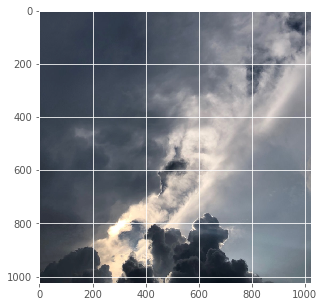

In [9]:
# First load an image
import skimage
img = skimage.io.imread('https://i.imgur.com/lqyJ3ul.jpg')

# Be careful with the size of your image.
# Try a fairly small image to begin with,
# then come back here and try larger sizes.
# img = skimage.transform.resize(img, (100, 100))
img = skimage.transform.resize(img, (1024, 1024))
plt.figure(figsize=(5, 5))
plt.imshow(img)

# Make sure you save this image as "reference.png"
# and include it in your zipped submission file
# so we can tell what image you are trying to paint!
plt.imsave(fname='reference.png', arr=img)

In the lecture, I showed how to aggregate the pixel locations and their colors using a loop over every pixel position.  I put that code into a function `split_image` below.  Feel free to experiment with other features for `xs` or `ys`.

In [10]:
def split_image(img):
    # We'll first collect all the positions in the image in our list, xs
    xs = []

    # And the corresponding colors for each of these positions
    ys = []

    # Now loop over the image
    for row_i in range(img.shape[0]):
        for col_i in range(img.shape[1]):
            # And store the inputs
            xs.append([row_i, col_i])
            # And outputs that the network needs to learn to predict
            ys.append(img[row_i, col_i])

    # we'll convert our lists to arrays
    xs = np.array(xs)
    ys = np.array(ys)
    return xs, ys

Let's use this function to create the inputs (xs) and outputs (ys) to our network as the pixel locations (xs) and their colors (ys):

In [11]:
xs, ys = split_image(img)

# and print the shapes
xs.shape, ys.shape

((1048576, 2), (1048576, 3))

Also remember, we should normalize our input values!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [12]:
# Normalize the input (xs) using its mean and standard deviation
xs = (xs - xs.mean()) / xs.std()

# Just to make sure you have normalized it correctly:
print(np.min(xs), np.max(xs))
assert(np.min(xs) > -3.0 and np.max(xs) < 3.0)

-1.7303601768 1.7303601768


Similarly for the output:

In [13]:
print(np.min(ys), np.max(ys))

0.0274509803922 1.0


We'll normalize the output using a simpler normalization method, since we know the values range from 0-255:

In [14]:
#ys = ys / 255.0
print(np.min(ys), np.max(ys))
print(ys[0])

0.0274509803922 1.0
[ 0.20392157  0.23137255  0.29411765]


Scaling the image values like this has the advantage that it is still interpretable as an image, unlike if we have negative values.

What we're going to do is use regression to predict the value of a pixel given its (row, col) position.  So the input to our network is `X = (row, col)` value.  And the output of the network is `Y = (r, g, b)`.

We can get our original image back by reshaping the colors back into the original image shape.  This works because the `ys` are still in order:

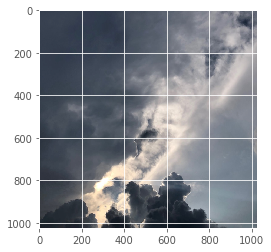

In [15]:
plt.imshow(ys.reshape(img.shape))

But when we give inputs of (row, col) to our network, it won't know what order they are, because we will randomize them.  So it will have to *learn* what color value should be output for any given (row, col).

Create 2 placeholders of `dtype` `tf.float32`: one for the input of the network, a `None x 2` dimension placeholder called $\textbf{X}$, and another for the true output of the network, a `None x 3` dimension placeholder called $\textbf{Y}$.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [16]:
# Let's reset the graph:
tf.reset_default_graph()

# Create a placeholder of None x 2 dimensions and dtype tf.float32
# This will be the input to the network which takes the row/col
X = tf.placeholder(tf.float32, shape=(None, 2))

# Create the placeholder, Y, with 3 output dimensions instead of 2.
# This will be the output of the network, the R, G, B values.
Y = tf.placeholder(tf.float32, shape=(None, 3))

Now create a deep neural network that takes your network input $\textbf{X}$ of 2 neurons, multiplies it by a linear and non-linear transformation which makes its shape [None, 20], meaning it will have 20 output neurons.  Then repeat the same process again to give you 20 neurons again, and then again and again until you've done 6 layers of 20 neurons.  Then finally one last layer which will output 3 neurons, your predicted output, which I've been denoting mathematically as $\hat{\textbf{Y}}$, for a total of 6 hidden layers, or 8 layers total including the input and output layers.  Mathematically, we'll be creating a deep neural network that looks just like the previous fully connected layer we've created, but with a few more connections. So recall the first layer's connection is:

\begin{align}
\textbf{H}_1=\phi(\textbf{X}\textbf{W}_1 + \textbf{b}_1) \\
\end{align}

So the next layer will take that output, and connect it up again:

\begin{align}
\textbf{H}_2=\phi(\textbf{H}_1\textbf{W}_2 + \textbf{b}_2) \\
\end{align}

And same for every other layer:

\begin{align}
\textbf{H}_3=\phi(\textbf{H}_2\textbf{W}_3 + \textbf{b}_3) \\
\textbf{H}_4=\phi(\textbf{H}_3\textbf{W}_4 + \textbf{b}_4) \\
\textbf{H}_5=\phi(\textbf{H}_4\textbf{W}_5 + \textbf{b}_5) \\
\textbf{H}_6=\phi(\textbf{H}_5\textbf{W}_6 + \textbf{b}_6) \\
\end{align}

Including the very last layer, which will be the prediction of the network:

\begin{align}
\hat{\textbf{Y}}=\phi(\textbf{H}_6\textbf{W}_7 + \textbf{b}_7)
\end{align}

Remember if you run into issues with variable scopes/names, that you cannot recreate a variable with the same name! Revisit the section on <a href='#Variable-Scopes'>Variable Scopes</a> if you get stuck with name issues.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [17]:
# We'll create 6 hidden layers.  Let's create a variable
# to say how many neurons we want for each of the layers
# (try 20 to begin with, then explore other values)
n_neurons = 20

# Create the first linear + nonlinear layer which will
# take the 2 input neurons and fully connects it to 20 neurons.
# Use the `utils.linear` function to do this just like before,
# but also remember to give names for each layer, such as
# "1", "2", ... "5", or "layer1", "layer2", ... "layer6".
h1, W1 = utils.linear(X, n_neurons, activation=tf.nn.relu, name='layer1', reuse=tf.AUTO_REUSE)

for i in range(2, 7):
    h1, W1 = utils.linear(h1, n_neurons, activation=tf.nn.relu, name='layer{}'.format(i), reuse=tf.AUTO_REUSE)

# # Create another one:
# h2, W2 = utils.linear(h1, 3, activation=tf.nn.relu, name='layer1')

# # and four more (or replace all of this with a loop if you can!):
# h3, W3 = utils.linear(h1, 3, activation=tf.nn.relu, name='layer')
# h4, W4 = utils.linear(h1, 3, activation=tf.nn.relu, name='layer1')
# h5, W5 = utils.linear(h1, 3, activation=tf.nn.relu, name='layer1')
# h6, W6 = utils.linear(h1, 3, activation=tf.nn.relu, name='layer1')

# Now, make one last layer to make sure your network has 3 outputs:
Y_pred, W7 = utils.linear(h1, 3, activation=None, name='pred')

In [18]:
assert(X.get_shape().as_list() == [None, 2])
assert(Y_pred.get_shape().as_list() == [None, 3])
assert(Y.get_shape().as_list() == [None, 3])

<a name="cost-function"></a>
## Cost Function

Now we're going to work on creating a `cost` function.  The cost should represent how much `error` there is in the network, and provide the optimizer this value to help it train the network's parameters using gradient descent and backpropagation.

Let's say our error is `E`, then the cost will be:

$$cost(\textbf{Y}, \hat{\textbf{Y}}) = \frac{1}{\text{B}} \displaystyle\sum\limits_{b=0}^{\text{B}} \textbf{E}_b
$$

where the error is measured as, e.g.:

$$\textbf{E} = \displaystyle\sum\limits_{c=0}^{\text{C}} (\textbf{Y}_{c} - \hat{\textbf{Y}}_{c})^2$$

Don't worry if this scares you.  This is mathematically expressing the same concept as: "the cost of an actual $\textbf{Y}$, and a predicted $\hat{\textbf{Y}}$ is equal to the mean across batches, of which there are $\text{B}$ total batches, of the sum of distances across $\text{C}$ color channels of every predicted output and true output".  Basically, we're trying to see on average, or at least within a single minibatches average, how wrong was our prediction?  We create a measure of error for every output feature by squaring the predicted output and the actual output it should have, i.e. the actual color value it should have output for a given input pixel position.  By squaring it, we penalize large distances, but not so much small distances.

Consider how the square function (i.e., $f(x) = x^2$) changes for a given error.  If our color values range between 0-255, then a typical amount of error would be between $0$ and $128^2$.  For example if my prediction was (120, 50, 167), and the color should have been (0, 100, 120), then the error for the Red channel is (120 - 0) or 120.  And the Green channel is (50 - 100) or -50, and for the Blue channel, (167 - 120) = 47.  When I square this result, I get: (120)^2, (-50)^2, and (47)^2.  I then add all of these and that is my error, $\textbf{E}$, for this one observation.  But I will have a few observations per minibatch.  So I add all the error in my batch together, then divide by the number of observations in the batch, essentially finding the mean error of my batch.  

Let's try to see what the square in our measure of error is doing graphically.

Text(0,0.5,'loss')

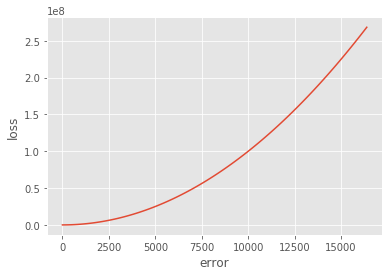

In [19]:
error = np.linspace(0.0, 128.0**2, 100)
loss = error**2.0
plt.plot(error, loss)
plt.xlabel('error')
plt.ylabel('loss')

This is known as the $l_2$ (pronounced el-two) loss.  It doesn't penalize small errors as much as it does large errors.  This is easier to see when we compare it with another common loss, the $l_1$ (el-one) loss.  It is linear in error, by taking the absolute value of the error.  We'll compare the $l_1$ loss with normalized values from $0$ to $1$.  So instead of having $0$ to $255$ for our RGB values, we'd have $0$ to $1$, simply by dividing our color values by $255.0$.

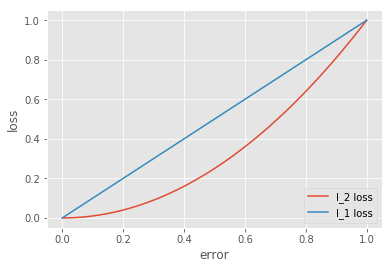

In [20]:
error = np.linspace(0.0, 1.0, 100)
plt.plot(error, error**2, label='l_2 loss')
plt.plot(error, np.abs(error), label='l_1 loss')
plt.xlabel('error')
plt.ylabel('loss')
plt.legend(loc='lower right')

So unlike the $l_2$ loss, the $l_1$ loss is really quickly upset if there is *any* error at all: as soon as error moves away from $0.0$, to $0.1$, the $l_1$ loss is $0.1$.  But the $l_2$ loss is $0.1^2 = 0.01$.  Having a stronger penalty on smaller errors often leads to what the literature calls "sparse" solutions, since it favors activations that try to explain as much of the data as possible, rather than a lot of activations that do a sort of good job,  but when put together, do a great job of explaining the data.  Don't worry about what this means if you are more unfamiliar with Machine Learning.  There is a lot of literature surrounding each of these loss functions that we won't have time to get into, but look them up if they interest you.

During the lecture, we've seen how to create a cost function using Tensorflow.  To create a $l_2$ loss function, you can for instance use tensorflow's `tf.squared_difference` or for an $l_1$ loss function, `tf.abs`.  You'll need to refer to the `Y` and `Y_pred` variables only, and your resulting cost should be a single value.  Try creating the $l_1$ loss to begin with, and come back here after you have trained your network, to compare the performance with a $l_2$ loss.

The equation for computing cost I mentioned above is more succintly written as, for $l_2$ norm:

$$cost(\textbf{Y}, \hat{\textbf{Y}}) = \frac{1}{\text{B}} \displaystyle\sum\limits_{b=0}^{\text{B}} \displaystyle\sum\limits_{c=0}^{\text{C}} (\textbf{Y}_{c} - \hat{\textbf{Y}}_{c})^2$$

For $l_1$ norm, we'd have:

$$cost(\textbf{Y}, \hat{\textbf{Y}}) = \frac{1}{\text{B}} \displaystyle\sum\limits_{b=0}^{\text{B}} \displaystyle\sum\limits_{c=0}^{\text{C}} \text{abs}(\textbf{Y}_{c} - \hat{\textbf{Y}}_{c})$$

Remember, to understand this equation, try to say it out loud: the $cost$ given two variables, $\textbf{Y}$, the actual output we want the network to have, and $\hat{\textbf{Y}}$ the predicted output from the network, is equal to the mean across $\text{B}$ batches, of the sum of $\textbf{C}$ color channels distance between the actual and predicted outputs.  If you're still unsure, refer to the lecture where I've computed this, or scroll down a bit to where I've included the answer.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [21]:
# first compute the error, the inner part of the summation.
# This should be the l1-norm or l2-norm of the distance
# between each color channel.
error = tf.abs(Y_pred - Y)
print(error.get_shape())
assert(error.get_shape().as_list() == [None, 3])

(?, 3)


<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [22]:
# Now sum the error for each feature in Y. 
# If Y is [Batch, Features], the sum should be [Batch]:
sum_error = tf.reduce_sum(error, 1)
assert(sum_error.get_shape().as_list() == [None])

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [23]:
# Finally, compute the cost, as the mean error of the batch.
# This should be a single value.
cost = tf.reduce_sum(sum_error)
assert(cost.get_shape().as_list() == [])

We now need an `optimizer` which will take our `cost` and a `learning_rate`, which says how far along the gradient to move.  This optimizer calculates all the gradients in our network with respect to the `cost` variable and updates all of the weights in our network using backpropagation.  We'll then create mini-batches of our training data and run the `optimizer` using a `session`.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [25]:
# Refer to the help for the function
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Create parameters for the number of iterations to run for (< 100)
n_iterations = 100

# And how much data is in each minibatch (< 500)
batch_size = 500

# Then create a session
sess = tf.Session()

We'll now train our network!  The code below should do this for you if you've setup everything else properly.  Please read through this and make sure you understand each step!  Note that this can take a VERY LONG time depending on the size of your image (make it < 100 x 100 pixels), the number of neurons per layer (e.g. < 30), the number of layers (e.g. < 8), and number of iterations (< 1000).  Welcome to Deep Learning :)

In [ ]:
# Initialize all your variables and run the operation with your session
sess.run(tf.global_variables_initializer())

# Optimize over a few iterations, each time following the gradient
# a little at a time
imgs = []
costs = []
gif_step = n_iterations // 10
step_i = 0

for it_i in range(n_iterations):
    
    # Get a random sampling of the dataset
    idxs = np.random.permutation(range(len(xs)))
    
    # The number of batches we have to iterate over
    n_batches = len(idxs) // batch_size
    
    # Now iterate over our stochastic minibatches:
    for batch_i in range(n_batches):
         
        # Get just minibatch amount of data
        idxs_i = idxs[batch_i * batch_size: (batch_i + 1) * batch_size]

        # And optimize, also returning the cost so we can monitor
        # how our optimization is doing.
        training_cost = sess.run(
            [cost, optimizer],
            feed_dict={X: xs[idxs_i], Y: ys[idxs_i]})[0]

    # Also, every 20 iterations, we'll draw the prediction of our
    # input xs, which should try to recreate our image!
    if (it_i + 1) % gif_step == 0:
        costs.append(training_cost / n_batches)
        ys_pred = Y_pred.eval(feed_dict={X: xs}, session=sess)
        img = np.clip(ys_pred.reshape(img.shape), 0, 1)
        imgs.append(img)
        # Plot the cost over time
        fig, ax = plt.subplots(1, 2)
        ax[0].plot(costs)
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('Cost')
        ax[1].imshow(img)
        fig.suptitle('Iteration {}'.format(it_i))
        plt.show()

In [ ]:
# Save the images as a GIF
#_ = gif.build_gif(imgs, saveto='single.gif', show_gif=False)
import imageio
_ = imageio.mimsave('single.gif', imgs)


Let's now display the GIF we've just created:

In [ ]:
ipyd.Image(url='single.gif?{}'.format(np.random.rand()),
           height=500, width=500)

<a name="explore"></a>
## Explore

Go back over the previous cells and exploring changing different parameters of the network.  I would suggest first trying to change the `learning_rate` parameter to different values and see how the cost curve changes.  What do you notice?  Try exponents of $10$, e.g. $10^1$, $10^2$, $10^3$... and so on.  Also try changing the `batch_size`: $50, 100, 200, 500, ...$ How does it effect how the cost changes over time?

Be sure to explore other manipulations of the network, such as changing the loss function to $l_2$ or $l_1$.  How does it change the resulting learning?  Also try changing the activation functions, the number of layers/neurons, different optimizers, and anything else that you may think of, and try to get a basic understanding on this toy problem of how it effects the network's training.  Also try comparing creating a fairly shallow/wide net (e.g. 1-2 layers with many neurons, e.g. > 100), versus a deep/narrow net (e.g. 6-20 layers with fewer neurons, e.g. < 20).  What do you notice?

<a name="a-note-on-crossvalidation"></a>
## A Note on Crossvalidation

The cost curve plotted above is only showing the cost for our "training" dataset.  Ideally, we should split our dataset into what are called "train", "validation", and "test" sets.  This is done by taking random subsets of the entire dataset.  For instance, we partition our dataset by saying we'll only use 80% of it for training, 10% for validation, and the last 10% for testing.  Then when training as above, you would only use the 80% of the data you had partitioned, and then monitor accuracy on both the data you have used to train, but also that new 10% of unseen validation data.  This gives you a sense of how "general" your network is.  If it is performing just as well on that 10% of data, then you know it is doing a good job.  Finally, once you are done training, you would test one last time on your "test" dataset.  Ideally, you'd do this a number of times, so that every part of the dataset had a chance to be the test set.  This would also give you a measure of the variance of the accuracy on the final test.  If it changes a lot, you know something is wrong.  If it remains fairly stable, then you know that it is a good representation of the model's accuracy on unseen data.

We didn't get a chance to cover this in class, as it is less useful for exploring creative applications, though it is very useful to know and to use in practice, as it avoids overfitting/overgeneralizing your network to all of the data.  Feel free to explore how to do this on the application above!

<a name="part-three---learning-more-than-one-image"></a>
# Part Three - Learning More than One Image

<a name="instructions-2"></a>
## Instructions

We're now going to make use of our Dataset from Session 1 and apply what we've just learned to try and paint every single image in our dataset.  How would you guess is the best way to approach this?  We could for instance feed in every possible image by having multiple row, col -> r, g, b values.  So for any given row, col, we'd have 100 possible r, g, b values.  This likely won't work very well as there are many possible values a pixel could take, not just one.  What if we also tell the network *which* image's row and column we wanted painted?  We're going to try and see how that does.

You can execute all of the cells below unchanged to see how this works with the first 100 images of the celeb dataset.  But you should replace the images with your own dataset, and vary the parameters of the network to get the best results!

I've placed the same code for running the previous algorithm into two functions, `build_model` and `train`.  You can directly call the function `train` with a 4-d image shaped as N x H x W x C, and it will collect all of the points of every image and try to predict the output colors of those pixels, just like before.  The only difference now is that you are able to try this with a few images at a time.  There are a few ways we could have tried to handle multiple images.  The way I've shown in the `train` function is to include an additional input neuron for *which* image it is.  So as well as receiving the row and column, the network will also receive as input which image it is as a number.  This should help the network to better distinguish the patterns it uses, as it has knowledge that helps it separates its process based on which image is fed as input.

In [ ]:
def build_model(xs, ys, n_neurons, n_layers, activation_fn,
                final_activation_fn, cost_type):
    
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    if xs.ndim != 2:
        raise ValueError(
            'xs should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
    if ys.ndim != 2:
        raise ValueError(
            'ys should be a n_observates x n_features, ' +
            'or a 2-dimensional array.')
        
    n_xs = xs.shape[1]
    n_ys = ys.shape[1]
    
    X = tf.placeholder(name='X', shape=[None, n_xs],
                       dtype=tf.float32)
    Y = tf.placeholder(name='Y', shape=[None, n_ys],
                       dtype=tf.float32)

    current_input = X
    for layer_i in range(n_layers):
        current_input = utils.linear(
            current_input, n_neurons,
            activation=activation_fn,
            name='layer{}'.format(layer_i))[0]

    Y_pred = utils.linear(
        current_input, n_ys,
        activation=final_activation_fn,
        name='pred')[0]
    
    if cost_type == 'l1_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.abs(Y - Y_pred), 1))
    elif cost_type == 'l2_norm':
        cost = tf.reduce_mean(tf.reduce_sum(
                tf.squared_difference(Y, Y_pred), 1))
    else:
        raise ValueError(
            'Unknown cost_type: {}.  '.format(
            cost_type) + 'Use only "l1_norm" or "l2_norm"')
    
    return {'X': X, 'Y': Y, 'Y_pred': Y_pred, 'cost': cost}

In [86]:
def train(imgs,
          learning_rate=0.001,
          batch_size=200,
          n_iterations=10,
          gif_step=2,
          n_neurons=30,
          n_layers=10,
          activation_fn=tf.nn.relu,
          final_activation_fn=tf.nn.tanh,
          cost_type='l2_norm'):

    N, H, W, C = imgs.shape
    all_xs, all_ys = [], []
    for img_i, img in enumerate(imgs):
        xs, ys = split_image(img)
        all_xs.append(np.c_[xs, np.repeat(img_i, [xs.shape[0]])])
        all_ys.append(ys)
    xs = np.array(all_xs).reshape(-1, 3)
    xs = (xs - np.mean(xs, 0)) / np.std(xs, 0)
    ys = np.array(all_ys).reshape(-1, 3)
    ys = ys / 127.5 - 1

    g = tf.Graph()
    with tf.Session(graph=g) as sess:
        model = build_model(xs, ys, n_neurons, n_layers,
                            activation_fn, final_activation_fn,
                            cost_type)
        optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(model['cost'])
        sess.run(tf.global_variables_initializer())
        gifs = []
        costs = []
        step_i = 0
        for it_i in range(n_iterations):
            # Get a random sampling of the dataset
            idxs = np.random.permutation(range(len(xs)))

            # The number of batches we have to iterate over
            n_batches = len(idxs) // batch_size
            training_cost = 0

            # Now iterate over our stochastic minibatches:
            for batch_i in range(n_batches):

                # Get just minibatch amount of data
                idxs_i = idxs[batch_i * batch_size:
                              (batch_i + 1) * batch_size]

                # And optimize, also returning the cost so we can monitor
                # how our optimization is doing.
                cost = sess.run(
                    [model['cost'], optimizer],
                    feed_dict={model['X']: xs[idxs_i],
                               model['Y']: ys[idxs_i]})[0]
                training_cost += cost

            print('iteration {}/{}: cost {}'.format(
                    it_i + 1, n_iterations, training_cost / n_batches))

            # Also, every 20 iterations, we'll draw the prediction of our
            # input xs, which should try to recreate our image!
            if (it_i + 1) % gif_step == 0:
                costs.append(training_cost / n_batches)
                ys_pred = model['Y_pred'].eval(
                    feed_dict={model['X']: xs}, session=sess)
                img = ys_pred.reshape(imgs.shape)
                gifs.append(img)
        return gifs

<a name="code-1"></a>
## Code

Below, I've shown code for loading the first 100 celeb files.  Run through the next few cells to see how this works with the celeb dataset, and then come back here and replace the `imgs` variable with your own set of images.  For instance, you can try your entire sorted dataset from Session 1 as an N x H x W x C array.  Explore!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

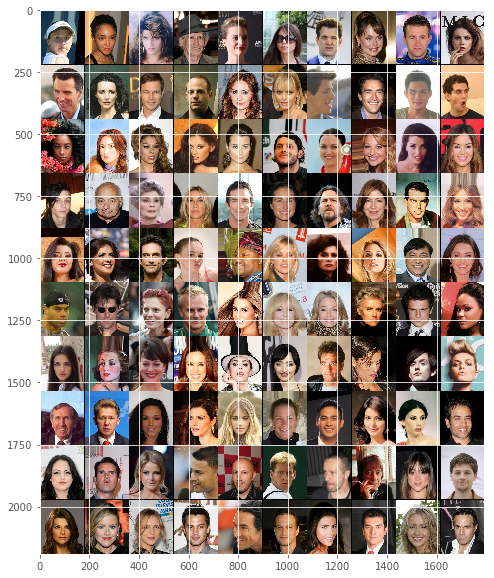

In [87]:
celeb_imgs = utils.get_celeb_imgs()
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(celeb_imgs).astype(np.uint8))
# It doesn't have to be 100 images, explore!
imgs = np.array(celeb_imgs).copy()

Explore changing the parameters of the `train` function and your own dataset of images.  Note, you do not have to use the dataset from the last assignment!  Explore different numbers of images, whatever you prefer.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Change the parameters of the train function and
# explore changing the dataset
gifs = train(imgs=imgs)

Now we'll create a gif out of the training process.  Be sure to call this 'multiple.gif' for your homework submission:

In [ ]:
montage_gifs = [np.clip(utils.montage(
            (m * 127.5) + 127.5), 0, 255).astype(np.uint8)
                for m in gifs]
_ = gif.build_gif(montage_gifs, saveto='multiple.gif')

And show it in the notebook

In [ ]:
ipyd.Image(url='multiple.gif?{}'.format(np.random.rand()),
           height=500, width=500)

What we're seeing is the training process over time.  We feed in our `xs`, which consist of the pixel values of each of our 100 images, it goes through the neural network, and out come predicted color values for every possible input value.  We visualize it above as a gif by seeing how at each iteration the network has predicted the entire space of the inputs.  We can visualize just the last iteration as a "latent" space, going from the first image (the top left image in the montage), to the last image, (the bottom right image).

In [ ]:
final = gifs[-1]
final_gif = [np.clip(((m * 127.5) + 127.5), 0, 255).astype(np.uint8) for m in final]
gif.build_gif(final_gif, saveto='final.gif')

In [ ]:
ipyd.Image(url='final.gif?{}'.format(np.random.rand()),
           height=200, width=200)

<a name="part-four---open-exploration-extra-credit"></a>
# Part Four - Open Exploration (Extra Credit)

I now what you to explore what other possible manipulations of the network and/or dataset you could imagine.  Perhaps a process that does the reverse, tries to guess where a given color should be painted?  What if it was only taught a certain palette, and had to reason about other colors, how it would interpret those colors?  Or what if you fed it pixel locations that weren't part of the training set, or outside the frame of what it was trained on?  Or what happens with different activation functions, number of layers, increasing number of neurons or lesser number of neurons?  I leave any of these as an open exploration for you.

Try exploring this process with your own ideas, materials, and networks, and submit something you've created as a gif!   To aid exploration, be sure to scale the image down quite a bit or it will require a much larger machine, and much more time to train.  Then whenever you think you may be happy with the process you've created, try scaling up the resolution and leave the training to happen over a few hours/overnight to produce something truly stunning!

Make sure to name the result of your gif: "explore.gif", and be sure to include it in your zip file.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Train a network to produce something, storing every few
# iterations in the variable gifs, then export the training
# over time as a gif.
...


gif.build_gif(montage_gifs, saveto='explore.gif')

In [ ]:
ipyd.Image(url='explore.gif?{}'.format(np.random.rand()),
           height=500, width=500)

<a name="assignment-submission"></a>
# Assignment Submission

After you've completed the notebook, create a zip file of the current directory using the code below.  This code will make sure you have included this completed ipython notebook and the following files named exactly as:

<pre>
    session-2/
      session-2.ipynb
      single.gif
      multiple.gif
      final.gif
      explore.gif*
      libs/
        utils.py
        
    * = optional/extra-credit
</pre>

You'll then submit this zip file for your second assignment on Kadenze for "Assignment 2: Teach a Deep Neural Network to Paint"!  If you have any questions, remember to reach out on the forums and connect with your peers or with me.

To get assessed, you'll need to be a premium student!  This will allow you to build an online portfolio of all of your work and receive grades.  If you aren't already enrolled as a student, register now at http://www.kadenze.com/ and join the [#CADL](https://twitter.com/hashtag/CADL) community to see what your peers are doing! https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info

Also, if you share any of the GIFs on Facebook/Twitter/Instagram/etc..., be sure to use the #CADL hashtag so that other students can find your work!

In [ ]:
utils.build_submission('session-2.zip',
                       ('reference.png',
                        'single.gif',
                        'multiple.gif',
                        'final.gif',
                        'session-2.ipynb'),
                       ('explore.gif'))